In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [ ]:
import keras

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

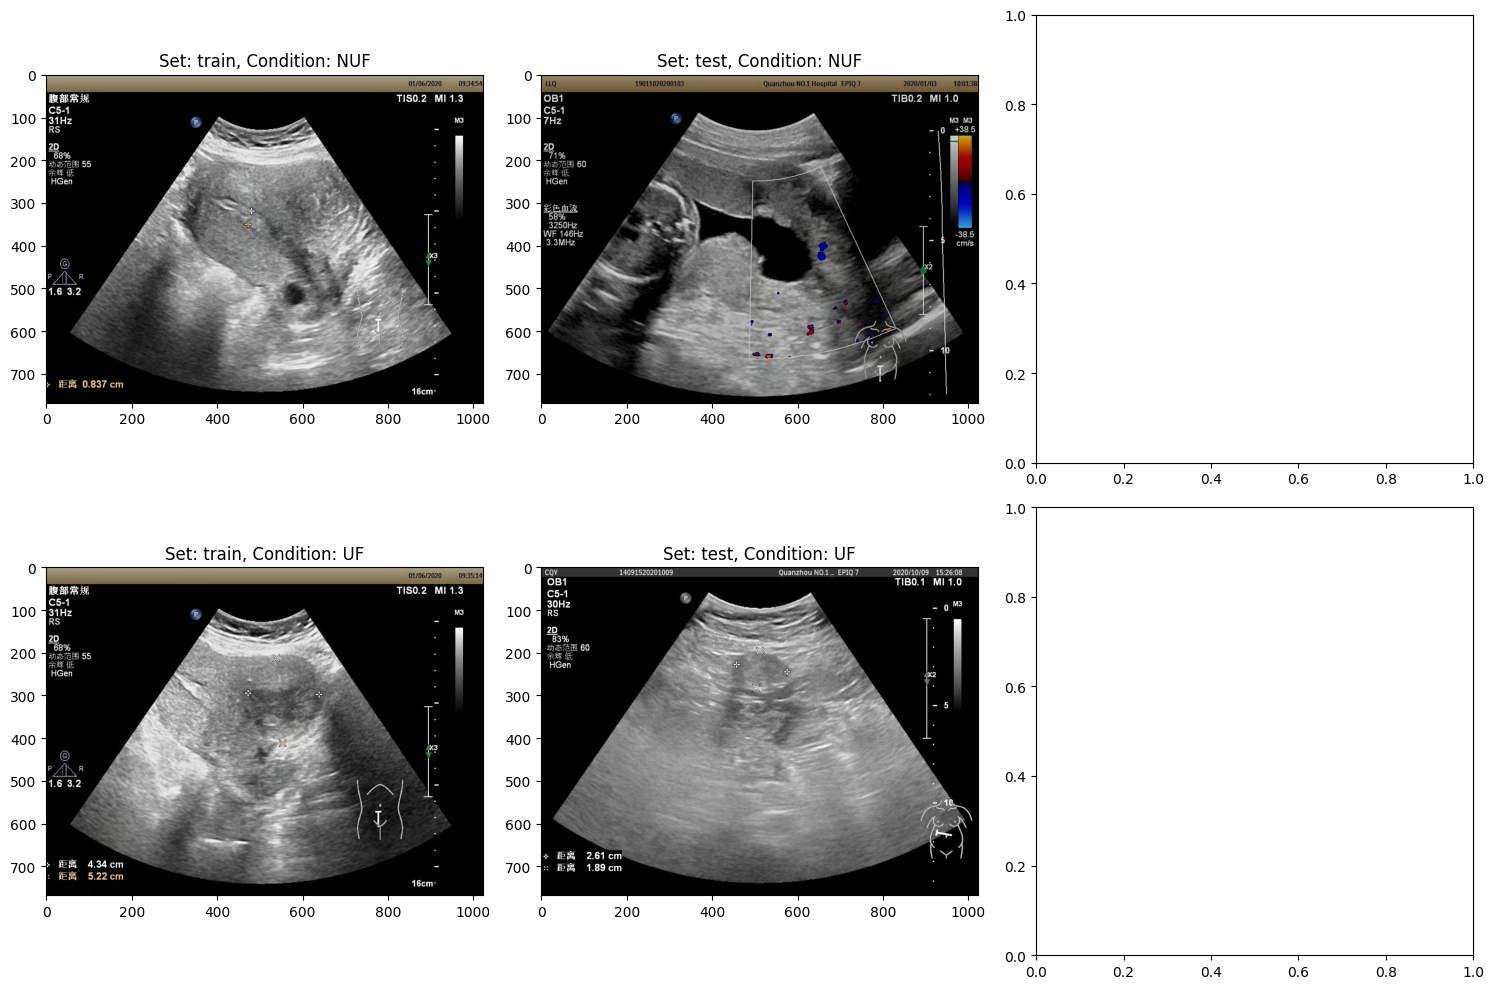

In [ ]:
path = '/content/drive/MyDrive/Datasets/'

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'test']):
    set_path = path + _set
    ax[i].imshow(plt.imread(set_path+'/NUF/'+os.listdir(set_path+'/NUF')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: NUF'.format(_set))

    ax[i+3].imshow(plt.imread(set_path+'/UF/'+os.listdir(set_path+'/UF')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: UF'.format(_set))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Define directories for training and testing data
train_dir = '/content/drive/MyDrive/Datasets/train'
test_dir = '/content/drive/MyDrive/Datasets/test'

batch_size = 32
image_size = (256,256)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

# Data Augmentation for Test Set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')



Found 1594 images belonging to 2 classes.
Found 396 images belonging to 2 classes.


In [ ]:
class_indices = train_generator.class_indices

# Print all the classes
classes = list(class_indices.keys())
print("Classes:", classes)

Classes: ['NUF', 'UF']


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                        

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/10
49/49 [==============================] - 614s 12s/step - loss: 2.9530 - accuracy: 0.6690 - val_loss: 0.6546 - val_accuracy: 0.6771
Epoch 2/10
49/49 [==============================] - 41s 840ms/step - loss: 0.9275 - accuracy: 0.7209 - val_loss: 3.8046 - val_accuracy: 0.4349
Epoch 3/10
49/49 [==============================] - 41s 839ms/step - loss: 0.5984 - accuracy: 0.7414 - val_loss: 6.1168 - val_accuracy: 0.4297
Epoch 4/10
49/49 [==============================] - 41s 820ms/step - loss: 0.5304 - accuracy: 0.7734 - val_loss: 1.9383 - val_accuracy: 0.5547
Epoch 5/10
49/49 [==============================] - 39s 801ms/step - loss: 0.5514 - accuracy: 0.7798 - val_loss: 3.4325 - val_accuracy: 0.5469
Epoch 6/10
49/49 [==============================] - 42s 852ms/step - loss: 0.5291 - accuracy: 0.7663 - val_loss: 1.6704 - val_accuracy: 0.2812
Epoch 7/10
49/49 [==============================] - 42s 862ms/step - loss: 0.4426 - accuracy: 0.7894 - val_loss: 2.9151 - val_accuracy: 0.3620


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

13/13 [==============================] - 4s 293ms/step - loss: 0.4041 - accuracy: 0.7904
Test accuracy: 0.7904040217399597


In [ ]:
model.save('uterine_fibroid_classification_model_cnn12.h5')

In [ ]:
# Load the trained model
from tensorflow.keras.models import load_model
model = load_model('uterine_fibroid_classification_model_cnn12.h5')

# Load the ultrasound image
image = cv2.imread('/content/5046.jpg')

# Preprocess the image
image = cv2.resize(image, (256, 256))  # Resize to match input dimensions
image = image / 255.0  # Normalize pixel values
image = image.reshape(1, 256,256, 3)  # Reshape to match input shape

# Make predictions
predictions = model.predict(image)

# Interpret predictions
if predictions[0] > 0.5:
    print("The ultrasound image contains a uterine fibroid.")
else:
    print("The ultrasound image does not contain a uterine fibroid.")


1/1 [==============================] - 0s 105ms/step
The ultrasound image does not contain a uterine fibroid.
